# Project 2: Thermoelectric Generator

## Import and Install Libraries

In [1]:
%%capture
%pip install pandas pyfluids sympy scipy numpy matplotlib openpyxl tqdm tabulate

import pandas as pd # This makes nice tables
import pyfluids # This does the thermodynamics
import math
import numpy as np
from scipy.optimize import fsolve, root
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from tabulate import tabulate

In [2]:
from pyfluids import Fluid, FluidsList, Input

water = Fluid(FluidsList.Water)

## Power Requirements

In [3]:
voltage_required = 3.3 # Volts
total_power_draw = 0.7071899999999999 # Watts
current_required = 0.21429999999999996 # Amps
current_required

0.21429999999999996

In [4]:
zero_celsius = 273.15

## Heat Transfer Characteristics

In [5]:
teg_length = 0.03 # m
teg_thickness = 3.75e-3 # m
teg_conductivity = 1.72 # W/mK

teg_alpha = 0.96
teg_eps = 0.12

algae_temp = 35 # C

In [6]:
plate_length = 1.0 # m
plate_thickness = 0.005 # m
alum_conductivity = 237 # W/mK

teg_series = 5
teg_parallel = 3

teg_area = teg_length ** 2 * teg_series * teg_parallel

teg_count = teg_series * teg_parallel
print(100.0 * teg_area / (plate_length ** 2), "% of the plate is covered by TEGs")

1.3499999999999999 % of the plate is covered by TEGs


## Hourly Constants

In [7]:
# Load the Excel file into a pandas DataFrame
constant_frame = pd.read_excel('Project2Data/Hourly T,v,G.xlsx')
print(constant_frame.columns)

constant_frame['Hot Temp'] = 0.0
constant_frame['Cold Temp'] = 0.0
constant_frame['Amps'] = 0.0
constant_frame['Voltage'] = 0.0
constant_frame['Power'] = 0.0

constant_frame = constant_frame[constant_frame['Month'] != 9]
constant_frame

Index(['Month', 'Day', 'Hour', 'Beam Irradiance (W/m2)',
       'Ambient Temperature (C)', 'Wind Speed (m/s)'],
      dtype='object')


,Month,Day,Hour,Beam Irradiance (W/m2),Ambient Temperature (C),Wind Speed (m/s),Hot Temp,Cold Temp,Amps,Voltage,Power
0,6,1,0,0,21,0.8,0.0,0.0,0.0,0.0,0.0
1,6,1,1,0,21,0.8,0.0,0.0,0.0,0.0,0.0
2,6,1,2,0,20,0.7,0.0,0.0,0.0,0.0,0.0
3,6,1,3,0,20,0.7,0.0,0.0,0.0,0.0,0.0
4,6,1,4,0,20,0.7,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2203,8,31,19,0,28,1.6,0.0,0.0,0.0,0.0,0.0
2204,8,31,20,0,27,2.1,0.0,0.0,0.0,0.0,0.0
2205,8,31,21,0,27,2.6,0.0,0.0,0.0,0.0,0.0
2206,8,31,22,0,26,2.5,0.0,0.0,0.0,0.0,0.0


## Natural Convection for the Bottom of the Plate

In [8]:
def calcBeta(Tc,Tw):
    """
    Calculates Beta coefficient

    Parameters:
    -Tc (float): Temp (K) of the cold side of the thermoelectric generator
    -Th (float): Temp (K) of the hot side of the thermoelectric generator

    Returns:
    -beta (float): coefficient value
    """
    water_Amb = water.with_state(
      Input.pressure(101325), Input.temperature(Tw-273)
    )

    rhoAmb = water_Amb.density

    T = Tc - 273
    rho = (999.83952 + 16.945176 * T - 7.9870401E-3 * (T**2) - 49.170461E-6 * (T**3) + 105.56302E-9 * (T**4) - 280.54253E-12 * (T**5))/(1+16.897850E-3 * T)
    print(rho)

    beta = -1/rho * (rhoAmb-rho)/(Tw-Tc)
    return beta


In [9]:
def calcRalyeighNumber(beta, Tc, Tw, x, alpha):
    """
    Calculates RalyeighNumber

    Parameters:
    -Tc (float): Temp (K) of the cold side of the thermoelectric generator
    -beta (float): coefficient value
    -Tw (float): Temp (K) of the water
    -x (float): Length in meters
    -alpha (float)

    Returns:
    -RaX
    """
    #Find dT
    deltaT = Tc - Tw
    #Define Constants
    g = 9.81
    kinematic_viscosity = 8.005E-7
    #Calculate Ra
    Rax  = abs(g * beta * deltaT * (x)**3 / (kinematic_viscosity * alpha))
    return Rax

In [10]:
def bottomConvection(Tc,Tw,L,alpha):

    Pr = 6.9
    beta = calcBeta(Tc,Tw)
    
    #Calculate Ralyeigh Number at x = L
    RaL = calcRalyeighNumber(beta,Tc, Tw, L, alpha)

    assert RaL > 1e4 and RaL < 1e9, "Ralyeigh Number is out of bounds"
    
    NuL = 0.52 * Pr * RaL ** (1/5)

    kf = 0.598 # W/mK
    ha = NuL * kf / L

    return ha


## Forced Convection on Top of the Plate

In [11]:
def topForcedConvectionCoefficient(u,Lplate):
    """
    Calculates h for the top plate due to wind

    Parameters:
    -u (float): Wind speed (m/s)
    -Lplate (float):Length of solar abosrber (m)

    Returns:
    -ha (float): Convection coefficient (W/m^2 K)
    """
    #Forced Convection on the top of the plate
    #Constants for 
    kf = 0.0259 #W/(mk)
    kinematic_viscosity = 1.61E-5
    Pr = 0.71

    Re_crit = 5e5

    Re = u * Lplate / (kinematic_viscosity)
    
    if Re < Re_crit:
        NuL = 0.664 * Re ** (1/2) * Pr ** (1/3)
    else:
        A = 0.037 * Re_crit ** (4/5) - 0.664 * Re_crit ** (1/2)
        NuL = (0.037 * Re ** (4/5) - A) * Pr ** (1/3)
    ha = NuL * kf / Lplate

    return ha


## TEG

In [12]:
amps = pd.read_csv('Project2Data/Voltage and Current - Amps Verbose.csv')
volts = pd.read_csv('Project2Data/Voltage and Current - Volts Verbose.csv')

volts.describe()

,T cold,T hot,V
count,33.000000,33.000000,33.000000
mean,35.000000,175.000000,2.975152
std,10.968705,80.282704,1.629830
min,25.000000,50.000000,0.000000
25%,25.000000,100.000000,1.650000
50%,30.000000,175.000000,3.200000
75%,50.000000,250.000000,4.350000
max,50.000000,300.000000,5.450000


In [13]:
amps_interp = RegularGridInterpolator((amps['T cold'].unique(), amps['T hot'].unique()),
                                      amps['I'].to_numpy().reshape(
                                        len(amps['T cold'].unique()),
                                        len(amps['T hot'].unique())))
volts_interp = RegularGridInterpolator((volts['T cold'].unique(), volts['T hot'].unique()),
                                      volts['V'].to_numpy().reshape(
                                        len(volts['T cold'].unique()),
                                        len(volts['T hot'].unique())))

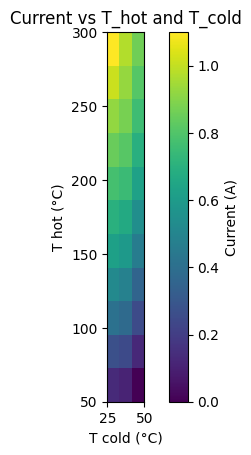

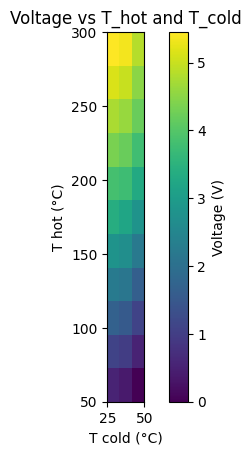

In [14]:
# Create a range of temperatures for interpolation
T_cold_range = volts['T cold'].unique()
T_hot_range = volts['T hot'].unique()

# Create a meshgrid of temperatures
T_cold_mesh, T_hot_mesh = np.meshgrid(T_cold_range, T_hot_range)

# Interpolate the current values
current_values = amps_interp((T_cold_mesh, T_hot_mesh))

# Interpolate the voltage values
voltage_values = volts_interp((T_cold_mesh, T_hot_mesh))

# Create a color plot of the current values
plt.figure()
plt.imshow(current_values, cmap='viridis', origin='lower', extent=[T_cold_range.min(), T_cold_range.max(), T_hot_range.min(), T_hot_range.max()])
plt.colorbar(label='Current (A)')
plt.xlabel('T cold (°C)')
plt.ylabel('T hot (°C)')
plt.title('Current vs T_hot and T_cold')

# Create a color plot of the voltage values
plt.figure()
plt.imshow(voltage_values, cmap='viridis', origin='lower', extent=[T_cold_range.min(), T_cold_range.max(), T_hot_range.min(), T_hot_range.max()])
plt.colorbar(label='Voltage (V)')
plt.xlabel('T cold (°C)')
plt.ylabel('T hot (°C)')
plt.title('Voltage vs T_hot and T_cold')

# Show the plots
plt.show()


C:\Users\willm\AppData\Local\Temp\ipykernel_2228\3170966780.py:9: RuntimeWarning: invalid value encountered in divide
  efficiency = product / heat_flux * 100.0


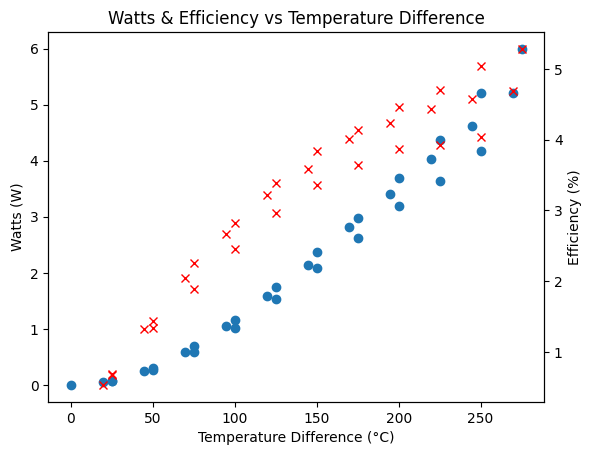

In [15]:
# Calculate the temperature difference
temp_diff = T_hot_mesh - T_cold_mesh

# Calculate the product of amps_interp and volts_interp
product = current_values * voltage_values

heat_flux = temp_diff * teg_length ** 2 * teg_conductivity / teg_thickness

efficiency = product / heat_flux * 100.0

# Plot the product against the temperature difference
fig, ax1 = plt.subplots()

ax1.plot(temp_diff.flatten(), product.flatten(), 'o')
ax1.set_xlabel('Temperature Difference (°C)')
ax1.set_ylabel('Watts (W)')
ax1.set_title('Watts & Efficiency vs Temperature Difference')

# Create a twin axis for efficiency
ax2 = ax1.twinx()
ax2.plot(temp_diff.flatten(), efficiency.flatten(), 'rx')
ax2.set_ylabel('Efficiency (%)')

plt.show()


## Heat Balance Equations

In [16]:
def updatedSolution(u, L_plate, T_algae, L, alpha, G, epsilon, Tamb, Kt, N, t, K_plate, plate_thickness):
    """
    Numerically solves for Th (Temp (K) of hot side of thermoelectric generator), and Tc (Temp (K) of cold side of thermoelectric generator)

    Parameters:
    -u (float): Wind speed (m/s)
    -L_plate (float):Length of solar abosrber (m)
    -L (float): length of thermoelectric generator module (m)
    -alpha (float):
    -G (float): 
    -epsilon (float): emmisivity 
    -Tamb (float): Ambient Temperature (K)
    -Kt (float): Thermal conductivity of the thermoelectric element
    -N (int): number of modules
    -t (float): Thickness of the thermoelectric element (m)
    """    

    L_sink = L_plate

    def residuals(vars):
        T_top, Th, Tc, T_bottom, h_w, rho = vars

        ha = topForcedConvectionCoefficient(u, L_plate)
        stefan = 5.67E-8

        top_plate = G * alpha - stefan * epsilon * Th ** 4 - ha * (T_top - Tamb)
        top_plate *= L_plate ** 2

        teg_conduction = N * L ** 2 * Kt / t

        effective_teg_length = L * N ** 0.5
        plate_effective_area = effective_teg_length * L_plate
        plate_conduction = plate_effective_area * K_plate / plate_thickness

        through_top =(T_top - Th) * plate_conduction

        through_gen = (Th - Tc) * teg_conduction

        through_bottom = (Tc - T_bottom) * plate_conduction

        into_water = h_w * (T_bottom - T_algae) * L_sink ** 2

        top = top_plate - through_top
        top_to_gen = through_top - through_gen
        gen_to_bottom = through_gen - through_bottom
        bottom_to_water = through_bottom - into_water

        # Calculate rho
        water_Amb = water.with_state(Input.pressure(101325), Input.temperature(T_algae-273))
        rhoAmb = water_Amb.density
        rho_expr = 999.83952 + 16.945176 * (Tc - 273)
        rho_expr -= 7.9870401E-3 * ((Tc - zero_celsius)**2) - 49.170461E-6 * ((Tc - zero_celsius)**3)
        rho_expr += 105.56302E-9 * ((Tc - zero_celsius)**4) - 280.54253E-12 * ((Tc - zero_celsius)**5)
        rho_expr /= 1+16.897850E-3 * (Tc - zero_celsius)
        rho_balance = rho - rho_expr

        Beta = -1/rho * (rhoAmb-rho)/(T_algae - Tc)

        # Calculate RaL
        deltaT = Tc - T_algae
        g = 9.81
        kinematic_viscosity = 8.005E-7
        RaL = abs(g * Beta * deltaT * (L_sink)**3 / (kinematic_viscosity * alpha))

        Pr = 6.9
        NuL = 0.68 + 0.670 * (RaL) ** (1/4) * (1 - (0.492/Pr) ** (9/16)) ** (-4/9)
        
        water_convective_coeff = h_w - NuL * 0.6 / L
        return [top, top_to_gen, gen_to_bottom, bottom_to_water, water_convective_coeff, rho_balance]

    initial_guess = [400, 390, 310, 300, 50, 900]
    s = root(residuals, initial_guess, method = 'lm')

    return s

In [17]:

def hourly_solve(irradiation, ambient_temp, wind_speed):
    sol = updatedSolution(u = wind_speed,
                      L_plate = plate_length,
                      T_algae = algae_temp + zero_celsius,
                      L = teg_length,
                      alpha = teg_alpha,
                      G = irradiation,
                      epsilon = teg_eps,
                      Tamb = ambient_temp + zero_celsius,
                      Kt = teg_conductivity,
                      N = teg_count,
                      t = teg_thickness,
                      K_plate = alum_conductivity,
                      plate_thickness = plate_thickness)
    if (sol.success):
      top_temp = sol.x[0] - zero_celsius
      hot_temp = sol.x[1] - zero_celsius
      cold_temp = sol.x[2] - zero_celsius
      bottom_temp = sol.x[3] - zero_celsius

      current = 0
      emf = 0

      if hot_temp > amps['T hot'].min() and hot_temp < amps['T hot'].max() and cold_temp > amps['T cold'].min() and cold_temp < amps['T cold'].max():
        try:
          current = amps_interp((cold_temp, hot_temp)) * teg_parallel
          emf = volts_interp((cold_temp, hot_temp)) * teg_series

          # print("Current:", current)
          # print("Voltage:", emf)
        except ValueError:
          print("Temperature out of range for interpolation @ {} C, {} C".format(cold_temp, hot_temp))
      return hot_temp, cold_temp, current, emf, top_temp, bottom_temp
      

min_irradiation = 4.38 * 1e3 / 12
min_avg_temp = 24
average_wind_speed = 3 # m/s

hourly_solve(min_irradiation, min_avg_temp, average_wind_speed)

(52.509397079987366,
 38.79288080691299,
 0.22424580961643836,
 1.4108071541964127,
 52.524821255192535,
 38.77745919334416)

## Hour by Hour Analysis

In [18]:
constant_frame.head()

,Month,Day,Hour,Beam Irradiance (W/m2),Ambient Temperature (C),Wind Speed (m/s),Hot Temp,Cold Temp,Amps,Voltage,Power
0,6,1,0,0,21,0.8,0.0,0.0,0.0,0.0,0.0
1,6,1,1,0,21,0.8,0.0,0.0,0.0,0.0,0.0
2,6,1,2,0,20,0.7,0.0,0.0,0.0,0.0,0.0
3,6,1,3,0,20,0.7,0.0,0.0,0.0,0.0,0.0
4,6,1,4,0,20,0.7,0.0,0.0,0.0,0.0,0.0


In [19]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

def solve(ind, row):
  return ind, hourly_solve(row['Beam Irradiance (W/m2)'], row['Ambient Temperature (C)'], row['Wind Speed (m/s)'])

with ThreadPoolExecutor() as executor:
  futures = [executor.submit(solve, ind, row) for ind, row in constant_frame.iterrows()]
  for future in tqdm(futures, total=len(constant_frame)):
    ind, result = future.result()
    if result is not None:
      constant_frame.at[ind, 'Hot Temp'] = result[0]
      constant_frame.at[ind, 'Cold Temp'] = result[1]
      constant_frame.at[ind, 'Amps'] = result[2]
      constant_frame.at[ind, 'Voltage'] = result[3]

100%|██████████| 2208/2208 [01:36<00:00, 22.99it/s] 


In [20]:
constant_frame['Power'] = constant_frame['Amps'] * constant_frame['Voltage']

In [21]:
constant_frame.describe()

,Month,Day,Hour,Beam Irradiance (W/m2),Ambient Temperature (C),Wind Speed (m/s),Hot Temp,Cold Temp,Amps,Voltage,Power
count,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000
mean,7.010870,15.836957,11.500000,261.366848,28.819746,2.562591,47.323767,37.542554,0.190922,1.331516,0.845916
std,0.814387,8.856232,6.923755,322.611788,4.916072,1.133573,26.481769,4.668027,0.290334,2.040018,1.483255
min,6.000000,1.000000,0.000000,0.000000,19.000000,0.300000,22.223423,31.580381,0.000000,0.000000,0.000000
25%,6.000000,8.000000,5.750000,0.000000,25.000000,1.700000,25.389513,34.729557,0.000000,0.000000,0.000000
50%,7.000000,16.000000,11.500000,32.000000,28.000000,2.500000,30.411351,35.892208,0.000000,0.000000,0.000000
75%,8.000000,23.250000,17.250000,562.250000,33.000000,3.400000,71.582813,38.504944,0.381249,2.639753,1.005534
max,8.000000,31.000000,23.000000,923.000000,41.000000,5.500000,113.311854,52.634468,1.125907,8.095908,9.115243


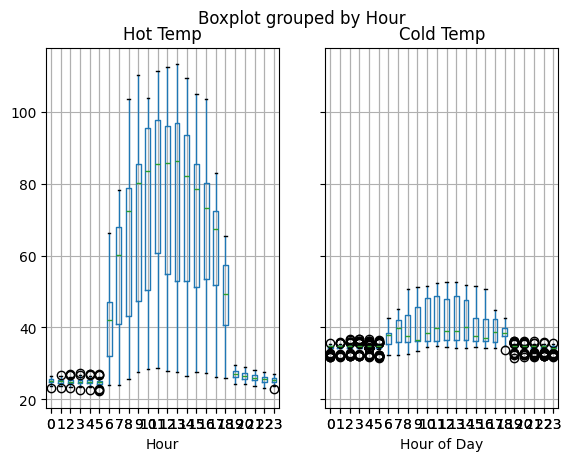

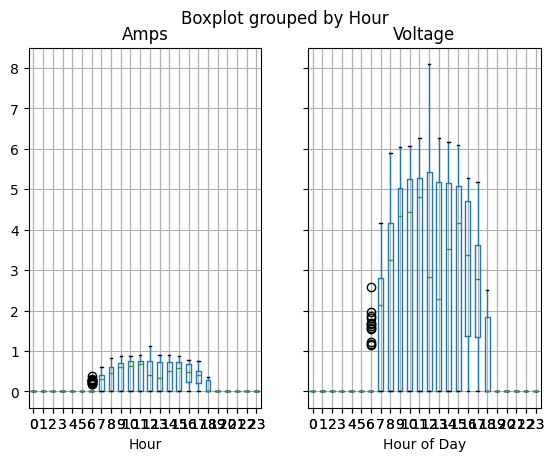

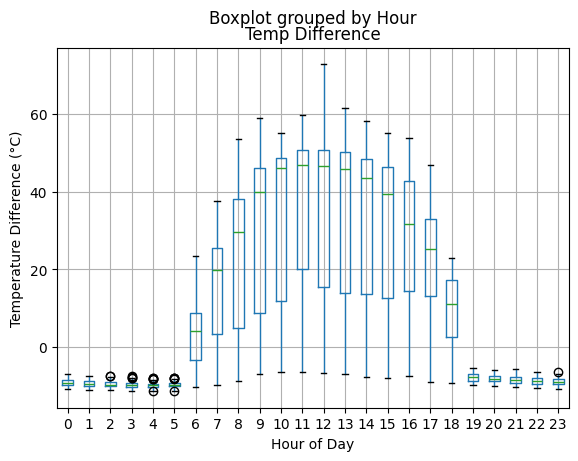

In [22]:
constant_frame.boxplot(column=['Hot Temp', 'Cold Temp'], by='Hour')
# plt.title('Temperature vs. Hour of Day')
plt.ylabel('Temperature (°C)')
plt.xlabel('Hour of Day')

constant_frame.boxplot(column=['Amps', 'Voltage'], by='Hour')
# plt.title('Current and Voltage vs. Hour of Day')
plt.ylabel('Value')
plt.xlabel('Hour of Day')

constant_frame['Temp Difference'] = constant_frame['Hot Temp'] - constant_frame['Cold Temp']
constant_frame.boxplot(column='Temp Difference', by='Hour')
# plt.title('Temperature Difference vs. Hour')
plt.ylabel('Temperature Difference (°C)')
plt.xlabel('Hour of Day')

plt.show()


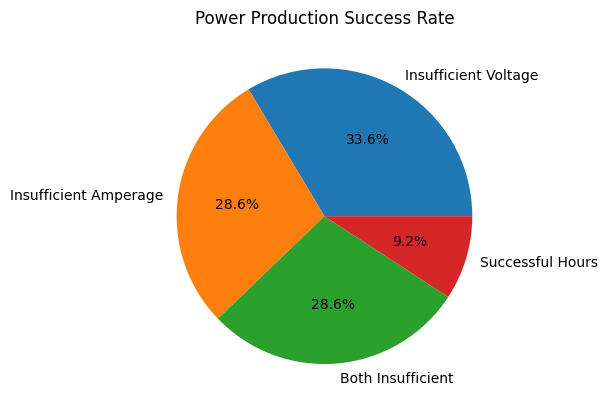

In [23]:
# Filter the dataframe to get the hours that fail to produce power
voltage_failed_hours = constant_frame[constant_frame['Voltage'] < voltage_required]
amps_failed_hours = constant_frame[constant_frame['Amps'] < current_required]
both_failed_hours = constant_frame[(constant_frame['Voltage'] < voltage_required) & (constant_frame['Amps'] < current_required)]

# Count the number of failed hours
voltage_failed_hours_count = len(voltage_failed_hours)
amps_failed_hours_count = len(amps_failed_hours)
both_failed_hours_count = len(both_failed_hours)

# Count the number of successful hours
successful_hours_count = len(constant_frame) - voltage_failed_hours_count - amps_failed_hours_count + both_failed_hours_count

# Create a pie chart
plt.pie([voltage_failed_hours_count, amps_failed_hours_count, both_failed_hours_count, successful_hours_count],
  labels=['Insufficient Voltage', 'Insufficient Amperage', 'Both Insufficient', 'Successful Hours'],
  autopct='%1.1f%%')
plt.title('Power Production Success Rate')

# Display the pie chart
plt.show()


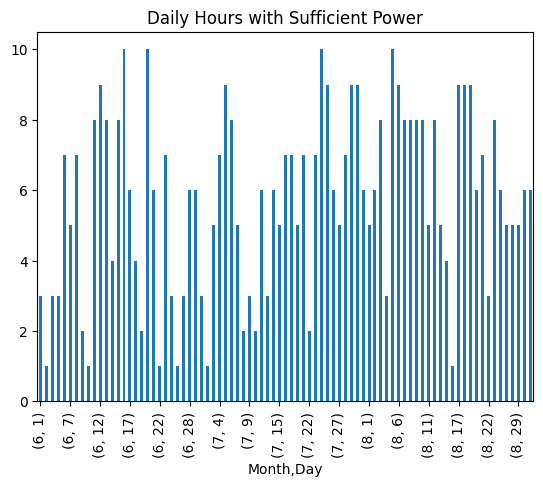

In [24]:
import matplotlib.pyplot as plt

# Group the dataframe by day and month, and sum the number of hours with > 3.3 Volts
hours_with_high_voltage = constant_frame[(constant_frame['Voltage'] > voltage_required) & (constant_frame['Amps'] > current_required)]\
                          .groupby([constant_frame['Month'], constant_frame['Day']]).size()

# Plot the number of hours with > 3.3 Volts by day and month
ax = hours_with_high_voltage.plot(kind='bar', title='Daily Hours with Sufficient Power')

# Set the x-axis labels interval
ax.set_xticks(range(0, len(hours_with_high_voltage), 5))

plt.show()


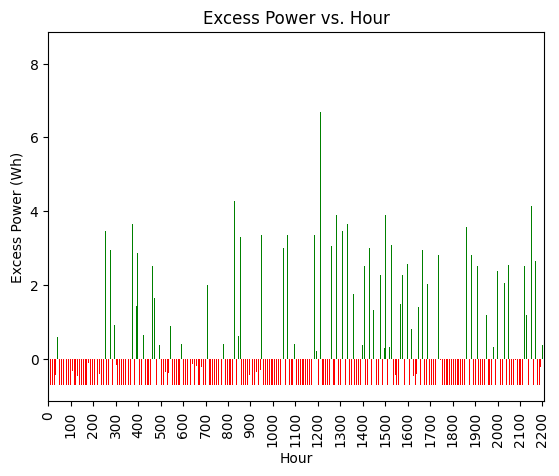

In [25]:
excess_power = constant_frame['Power'] - (voltage_required * current_required)

ax = excess_power.plot(kind='bar', color=['red' if x < 0 else 'green' for x in excess_power])
_ = ax.set_xlabel('Hour')
_ = ax.set_ylabel('Excess Power (Wh)')
_ = ax.set_title('Excess Power vs. Hour')

_ = ax.set_xticks(range(0, len(excess_power), 100))


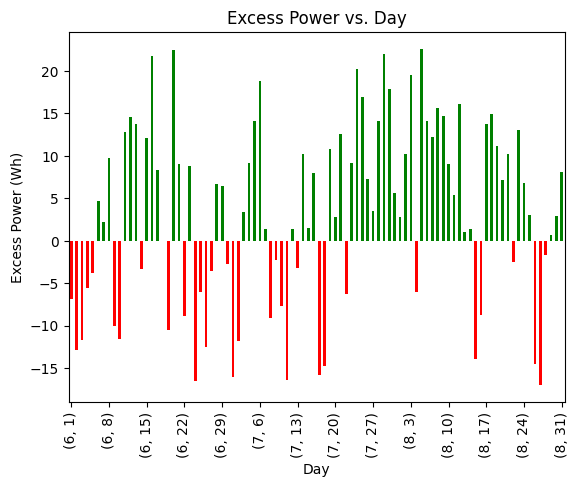

33

In [26]:
excess_power_day = constant_frame.groupby(['Month', 'Day'])['Power'].sum() - (voltage_required * current_required * 24)

ax = excess_power_day.plot(kind='bar', color=['red' if x < 0 else 'green' for x in excess_power_day])
_ = ax.set_xlabel('Day')
_ = ax.set_ylabel('Excess Power (Wh)')
_ = ax.set_title('Excess Power vs. Day')

# Show every 7 x-axis labels
_ = ax.set_xticks(range(0, len(excess_power_day), 7))

plt.show()

negative_days = (excess_power_day < 0).sum()
negative_days


To Bridge 888 Hours / 37.0 days, We need 627.9847199999999 Wh


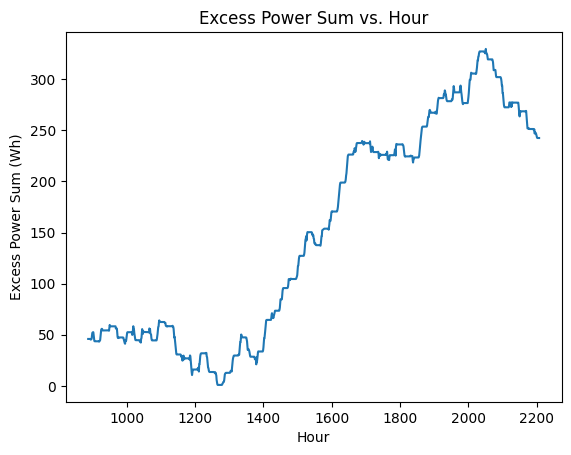

In [27]:
# Initialize variables to store the smallest window size and the corresponding excess power
smallest_window_size = None

for window_size in range(1, len(excess_power) + 1):
  excess_power_sum = excess_power.rolling(window=window_size).sum().dropna()

  if excess_power_sum.min() >= 0:
    smallest_window_size = window_size
    break

assert smallest_window_size is not None, "No window size found"

battery_requirement = smallest_window_size * total_power_draw
print("To Bridge", smallest_window_size, "Hours /", smallest_window_size / 24, "days, We need", battery_requirement, "Wh")

excess_power_sum.plot()
plt.xlabel('Hour')
plt.ylabel('Excess Power Sum (Wh)')
plt.title('Excess Power Sum vs. Hour')
plt.show()


In [28]:
max_power = constant_frame['Power'].max()
print("Maximum Power Production:", max_power, "W")

max_hot_temp = constant_frame['Hot Temp'].max()
print("Maximum Hot Side Temperature:", max_hot_temp, "°C")

average_power = constant_frame['Power'].mean()
print("Average Power Production:", average_power, "W")

total_watt_hours_captured = average_power * len(constant_frame)
num_hours_captured = len(constant_frame)

print("Total Joules Captured:", total_watt_hours_captured, "J")
print("Over", num_hours_captured, "hours")

table_data = [
  ["Maximum Power Production (W)", max_power],
  ["Maximum Hot Side Temperature (°C)", max_hot_temp],
  ["Average Power Production (W)", average_power],
  ["Total Watt Hours Captured (Wh)", total_watt_hours_captured],
  ["Annual Operation (hours)", num_hours_captured],
  ["Battery Requirement (Wh)", battery_requirement]
]

df = pd.DataFrame(table_data, columns=["Metric", "Value"])
df


Maximum Power Production: 9.11524286450715 W
Maximum Hot Side Temperature: 113.31185422535287 °C
Average Power Production: 0.8459162466218595 W
Total Joules Captured: 1867.7830725410658 J
Over 2208 hours


,Metric,Value
0,Maximum Power Production (W),9.115243
1,Maximum Hot Side Temperature (°C),113.311854
2,Average Power Production (W),0.845916
3,Total Watt Hours Captured (Wh),1867.783073
4,Annual Operation (hours),2208.000000
5,Battery Requirement (Wh),627.984720
